<a href="https://colab.research.google.com/github/facarranza/AVGN/blob/master/MONITORINGUES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install evidently

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 6.6 MB/s 
     |████████████████████████████████| 636 kB 54.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [ ]:
import datetime
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import json
from sklearn import datasets, ensemble, model_selection
from sklearn import datasets, ensemble, model_selection
from scipy.stats import anderson_ksamp

from evidently.dashboard import Dashboard
from evidently.pipeline.column_mapping import ColumnMapping
from evidently.dashboard.tabs import DataDriftTab, NumTargetDriftTab, RegressionPerformanceTab
from evidently.options import DataDriftOptions
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataDriftProfileSection, RegressionPerformanceProfileSection

https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset





In [ ]:
content = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip").content
with zipfile.ZipFile(io.BytesIO(content)) as arc:
    raw_data = pd.read_csv(arc.open("hour.csv"), header=0, sep=',', parse_dates=['dteday']) 

In [ ]:
raw_data.index = raw_data.apply(lambda row: datetime.datetime.combine(row.dteday.date(), datetime.time(row.hr)),
                                axis=1)

In [ ]:
raw_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
2011-01-01 00:00:00,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01 01:00:00,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01 02:00:00,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01 03:00:00,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01 04:00:00,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [ ]:
raw_data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [ ]:
raw_data.corr()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.404046,0.866014,0.489164,-0.004775,0.014723,0.001357,-0.003416,-0.014198,0.136178,0.137615,0.009577,-0.074505,0.158295,0.282046,0.278379
season,0.404046,1.000000,-0.010742,0.830386,-0.006117,-0.009585,-0.002335,0.013743,-0.014524,0.312025,0.319380,0.150625,-0.149773,0.120206,0.174226,0.178056
yr,0.866014,-0.010742,1.000000,-0.010473,-0.003867,0.006692,-0.004485,-0.002196,-0.019157,0.040913,0.039222,-0.083546,-0.008740,0.142779,0.253684,0.250495
mnth,0.489164,0.830386,-0.010473,1.000000,-0.005772,0.018430,0.010400,-0.003477,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.120638
hr,-0.004775,-0.006117,-0.003867,-0.005772,1.000000,0.000479,-0.003498,0.002285,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141,0.394071
holiday,0.014723,-0.009585,0.006692,0.018430,0.000479,1.000000,-0.102088,-0.252471,-0.017036,-0.027340,-0.030973,-0.010588,0.003988,0.031564,-0.047345,-0.030927
weekday,0.001357,-0.002335,-0.004485,0.010400,-0.003498,-0.102088,1.000000,0.035955,0.003311,-0.001795,-0.008821,-0.037158,0.011502,0.032721,0.021578,0.026900
workingday,-0.003416,0.013743,-0.002196,-0.003477,0.002285,-0.252471,0.035955,1.000000,0.044672,0.055390,0.054667,0.015688,-0.011830,-0.300942,0.134326,0.030284
weathersit,-0.014198,-0.014524,-0.019157,0.005400,-0.020203,-0.017036,0.003311,0.044672,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.142426
temp,0.136178,0.312025,0.040913,0.201691,0.137603,-0.027340,-0.001795,0.055390,-0.102640,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2016d85090>,
      dtype=object)

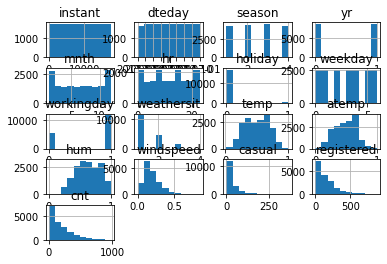

In [ ]:
raw_data.hist()

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   season      17379 non-null  int64         
 3   yr          17379 non-null  int64         
 4   mnth        17379 non-null  int64         
 5   hr          17379 non-null  int64         
 6   holiday     17379 non-null  int64         
 7   weekday     17379 non-null  int64         
 8   workingday  17379 non-null  int64         
 9   weathersit  17379 non-null  int64         
 10  temp        17379 non-null  float64       
 11  atemp       17379 non-null  float64       
 12  hum         17379 non-null  float64       
 13  windspeed   17379 non-null  float64       
 14  casual      17379 non-null  int64         
 15  registered  17379 non-null  int64  

In [ ]:
raw_data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [ ]:
target='cnt'
prediction='prediction'

numerical_features=['temp','atemp','hum','windspeed','mnth','hr','weekday']
categorical_features=['season','holiday','workingday']


In [ ]:
reference = raw_data.loc['2011-01-01 00:00:00':'2011-01-28 23:00:00']
current = raw_data.loc['2011-01-29 00:00:00':'2011-02-28 23:00:00']

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    reference[numerical_features + categorical_features],
    reference[target],
    test_size=0.3
)

In [ ]:
regressor = ensemble.RandomForestRegressor(random_state=0, n_estimators=50)

In [ ]:
regressor.fit(X_train,y_train)

RandomForestRegressor(n_estimators=50, random_state=0)

In [ ]:
preds_train=regressor.predict(X_train)
preds_test=regressor.predict(X_test)

In [ ]:
X_train['target'] = y_train
X_train['prediction'] = preds_train

In [ ]:
X_test['target'] = y_test
X_test['prediction'] = preds_test

In [ ]:
column_mapping = ColumnMapping()
column_mapping.target = 'target'
column_mapping.prediction = 'prediction'
column_mapping.numerical_features = numerical_features
column_mapping.categorical_features = categorical_features

In [ ]:
# dashboard de control

regression_performance_dashboard=Dashboard(tabs=[RegressionPerformanceTab()])
regression_performance_dashboard.calculate(X_train.sort_index(),X_test.sort_index(), column_mapping=column_mapping)
regression_performance_dashboard.show()


In [ ]:
current_prediction=regressor.predict(current[numerical_features+categorical_features])
current['prediction']=current_prediction

A la semana 1



In [ ]:
regression_perfomance_dashboard.calculate(reference, current.loc['2011-01-29 00:00:00':'2011-02-07 23:00:00'], 
                                            column_mapping=column_mapping)

NameError: ignored